In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

<module 'libs.params' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/params.py'>

In [2]:
import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
pd.set_option('display.max_columns', None)

import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs/AAPL_1_base.csv


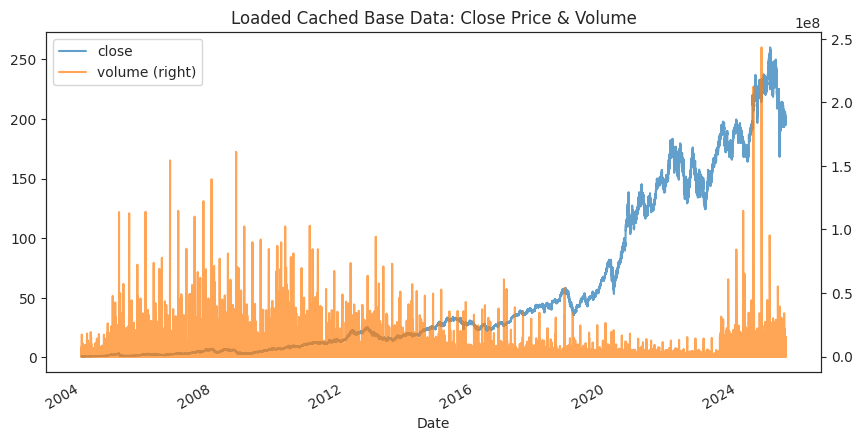

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764668    0.763904  
2004-01-02 09:01:00     28000.0    0.764668    0.763904  
2004-01-02 09:02:00     28000.0    0.764668    0.763904  
2004-01-02 09:03:00     28000.0    0.764668    0.763904  
2004-01-02 09:04:00     28000.0    0.764668    0.763904  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.913400  196.716600  
2025-06-18 20:57:00    460630.0  196.773300  196.576700  
2025-06-18 20:58:00    525245.0  196.768300  196.571700  
2025-06-18 20:59:00   2075503.0  196.338100  196.141900  
2025-06-18 21:00:00  15600625.0  196.638300  196.441700  

[3893400 rows x 7 columns]

In [3]:
base_csv = params.base_csv

if not params.createCSVbase and os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] Re-creating base CSV; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidask_spread_pct   = params.bidask_spread_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def saveDF_checkDAY(
    df: pd.DataFrame,
    best_optuna_params: Dict
) -> pd.DataFrame:
    """
    1) Slice df to the month in params.month_to_check ("YYYY-MM").
    2) Run the optimized pipeline over that month’s data:
       - The pipeline itself will group and simulate day by day.
       - Plot each day’s trades & equity.
       - Print per-day performance.
    3) If params.createCSVsign:
       • Rerun pipeline on the full df, aggregate & plot.
       • Save the full-run signals CSV.
       • Return the full-run DataFrame.
    4) Otherwise return the month’s concatenated signals/actions DataFrame.
    """
    # 1) Filter to the chosen month
    month_str = params.month_to_check    # e.g. "2023-09"
    print(f"\n=== Running pipeline for month {month_str} ===")

    # mask all rows whose index formatted as "YYYY-MM" equals month_to_check
    df_period = df[df.index.strftime("%Y-%m") == month_str].copy()
    if df_period.empty:
        print("No market data for this month; returning empty DataFrame.")
        return pd.DataFrame()

    # 2) Run pipeline on entire month slice
    result_by_day = trades.run_trading_pipeline(
        df           = df_period,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )
    if not result_by_day:
        print("No trades generated in this period; returning empty DataFrame.")
        return pd.DataFrame()

    # Unpack per-day results for plotting & stats
    month_frames = []
    month_stats  = []
    for day, (df_day, trades_day, perf_day) in result_by_day.items():
        print(f"-------------------------------------------------------------------------------------------------------------------------------------------------")
        plots.plot_trades(
            df                 = df_day,
            col_signal1        = "signal",
            col_signal2        = False,
            col_action         = "signal_action",
            trades             = trades_day,
            buy_threshold      = best_optuna_params["buy_threshold"],
            performance_stats  = perf_day,
            start_plot         = params.sess_start
        )
        for k, v in perf_day.items():
            print(f"  {k}: {v}")

        month_frames.append(df_day)
        month_stats.append(perf_day)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)
    
    # If not saving full-run CSV, just return the month’s results
    if not params.createCSVsign:
        return df_month

    # 3) Full-run backtest (same as before)
    print("\n******************** Running pipeline on full dataset ********************")
    full_results = trades.run_trading_pipeline(
        df           = df,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )

    # Build combined DF & perf list
    daily_frames = [res[0] for res in full_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_results.values()]
    plots.aggregate_performance(perf_all, df_all)

    # Test-period slice & performance
    all_days  = df_all.index.normalize().unique()
    cutoff    = int(len(all_days) * (params.train_prop + params.val_prop))
    test_days = all_days[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print(f"\nSaving full-run signals to {params.sign_csv} …")
    df_all.to_csv(params.sign_csv)
    print("CSV saved.")

    return df_all


best_optuna_value: 0.5146022222222223
best_optuna_params: {'min_prof_thr': 0.0342901435860898, 'max_down_prop': 0.90238165742582, 'gain_tightening_factor': 24.95286835227118, 'merging_retracement_thr': 0.49969219278242316, 'merging_time_gap_thr': 3.236169274940038, 'tau_time': 13, 'tau_dur': 204, 'trailing_stop_pct': 0.037492180108668366, 'buy_threshold': 0.3615539306704394, 'smoothing_window': 15}

=== Running pipeline for month 2023-10 ===
Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 3.36 ) & generating trade actions …


Simulating trading days: 100%|██████████| 22/22 [00:00<00:00, 29.11day/s]


-------------------------------------------------------------------------------------------------------------------------------------------------


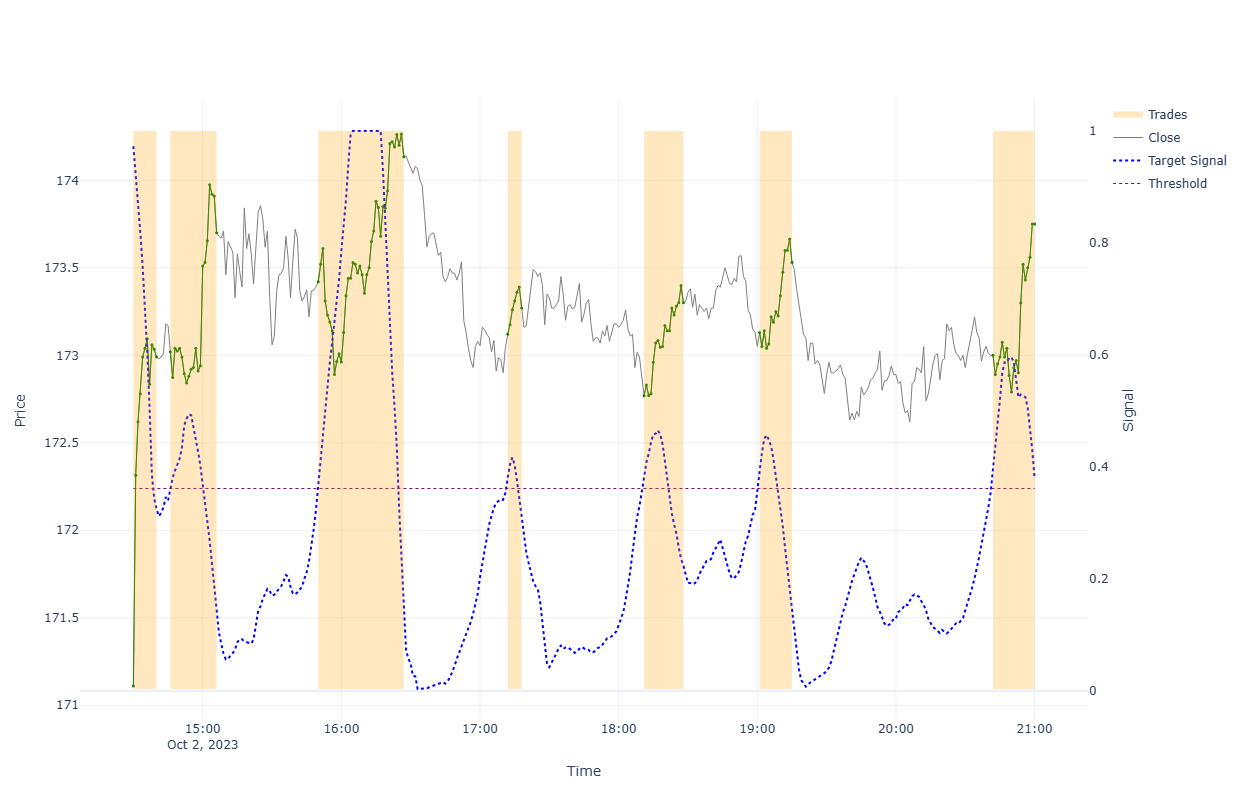

  Buy & Hold Return ($): 2.467
  Strategy Return ($): 3.894
  Trades Returns ($): [1.709, 0.507, 0.541, -0.023, 0.358, 0.227, 0.576]
-------------------------------------------------------------------------------------------------------------------------------------------------


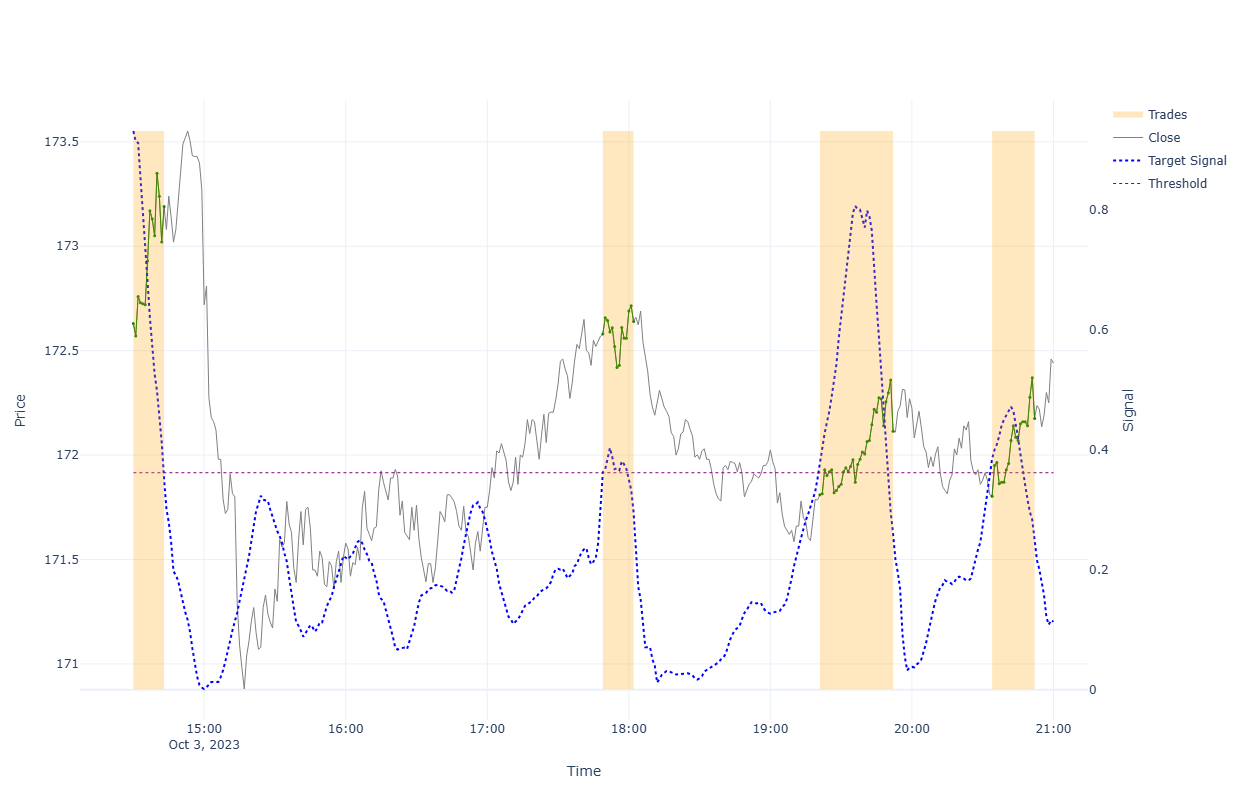

  Buy & Hold Return ($): -0.362
  Strategy Return ($): 0.606
  Trades Returns ($): [0.387, -0.112, 0.132, 0.199]
-------------------------------------------------------------------------------------------------------------------------------------------------


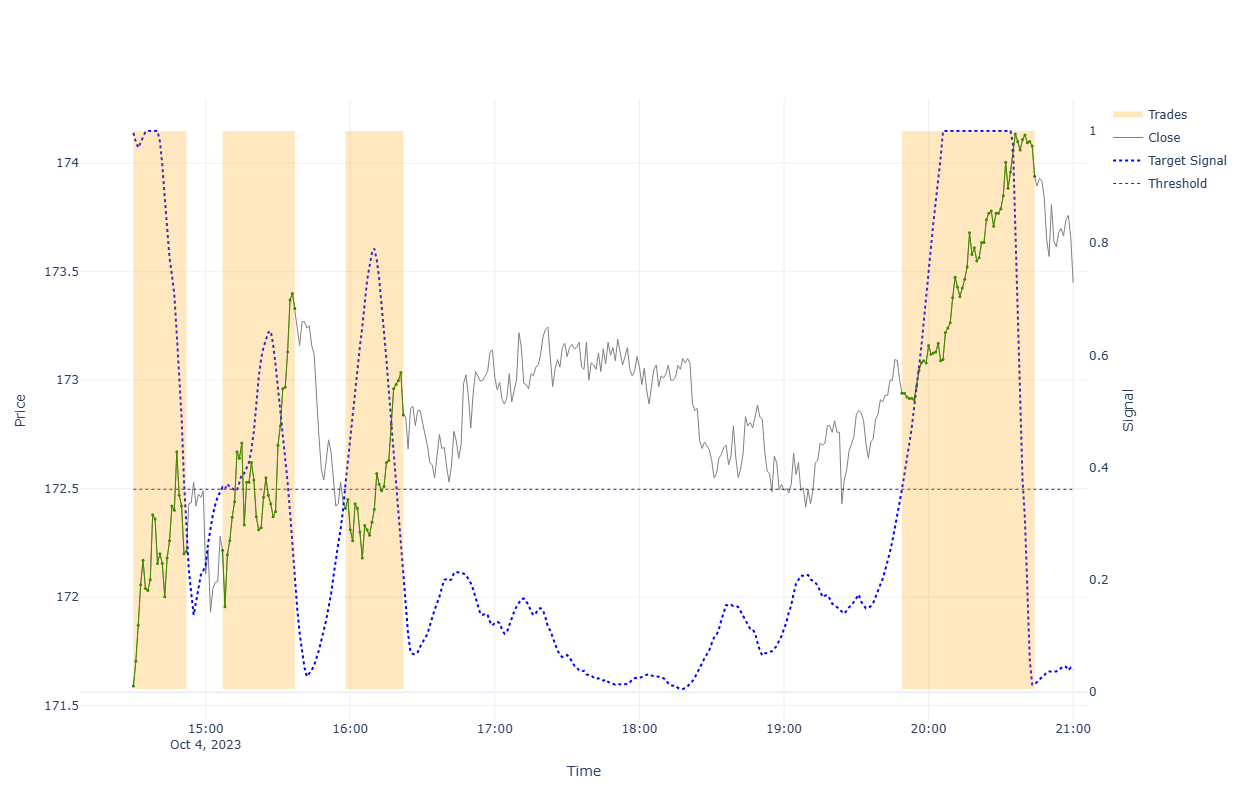

  Buy & Hold Return ($): 1.687
  Strategy Return ($): 2.474
  Trades Returns ($): [0.448, 0.942, 0.257, 0.827]
-------------------------------------------------------------------------------------------------------------------------------------------------


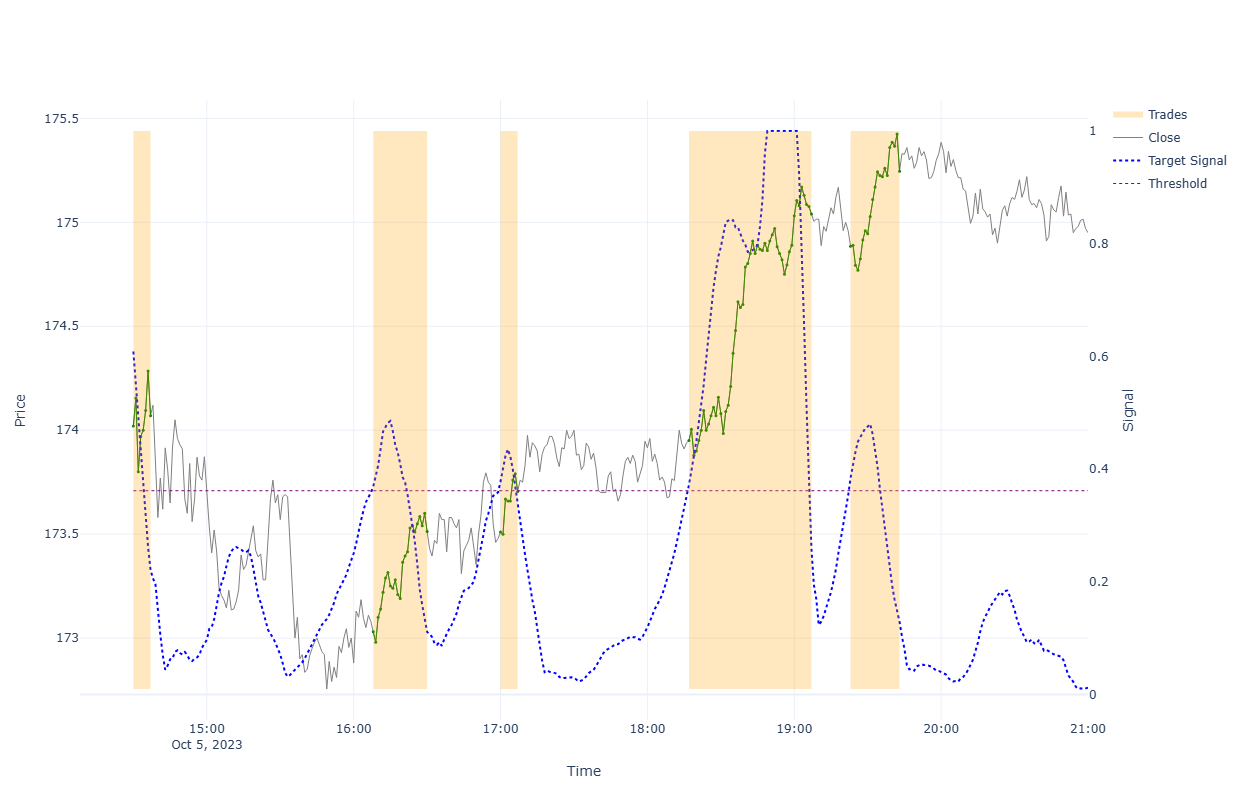

  Buy & Hold Return ($): 0.756
  Strategy Return ($): 1.309
  Trades Returns ($): [-0.124, 0.31, 0.021, 0.915, 0.185]
-------------------------------------------------------------------------------------------------------------------------------------------------


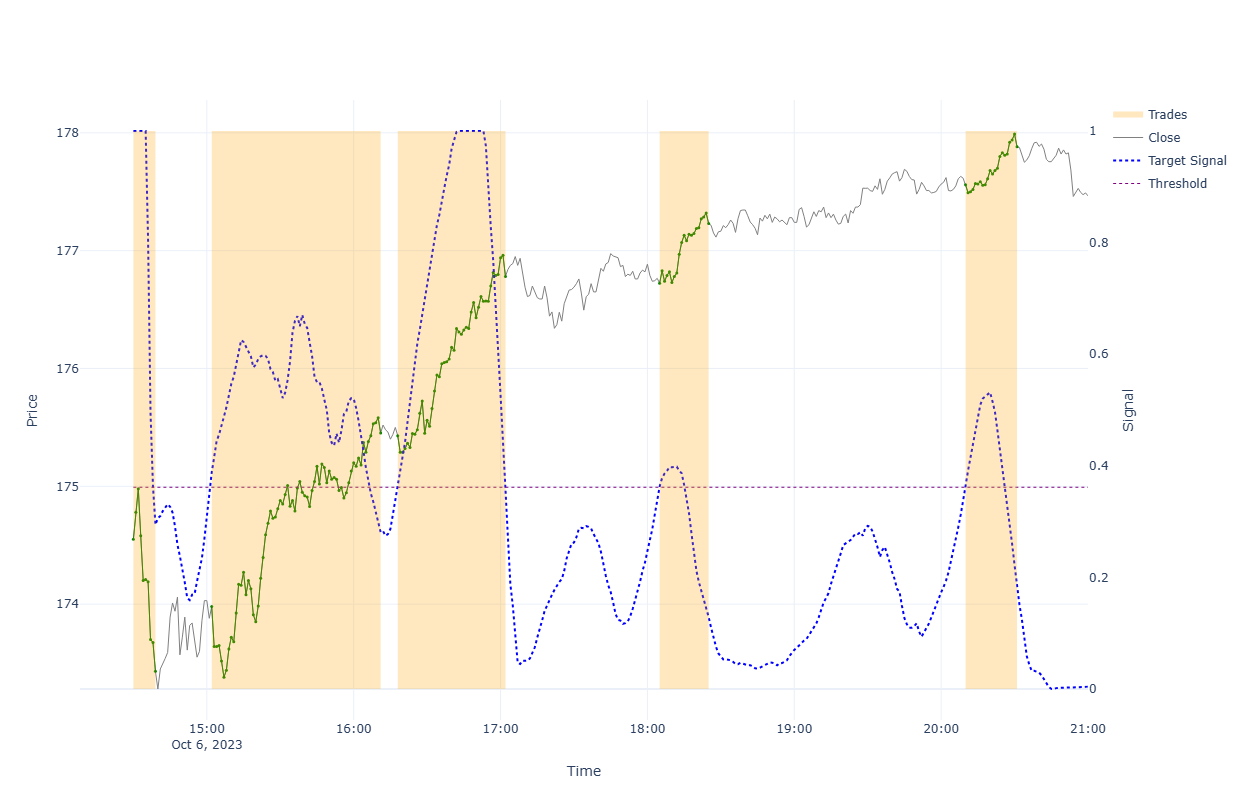

  Buy & Hold Return ($): 2.739
  Strategy Return ($): 1.649
  Trades Returns ($): [-1.294, 1.297, 1.174, 0.329, 0.144]
-------------------------------------------------------------------------------------------------------------------------------------------------


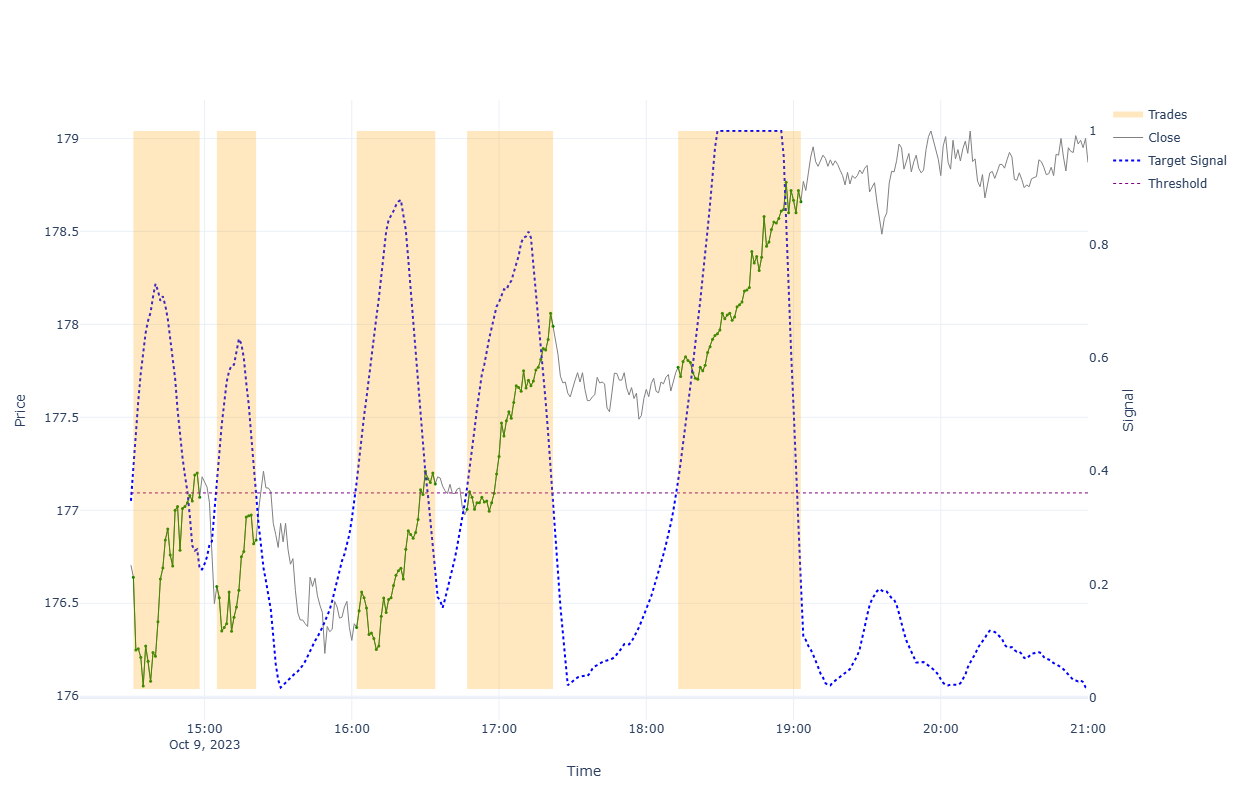

  Buy & Hold Return ($): 1.988
  Strategy Return ($): 2.44
  Trades Returns ($): [0.253, 0.072, 0.595, 0.808, 0.711]
-------------------------------------------------------------------------------------------------------------------------------------------------


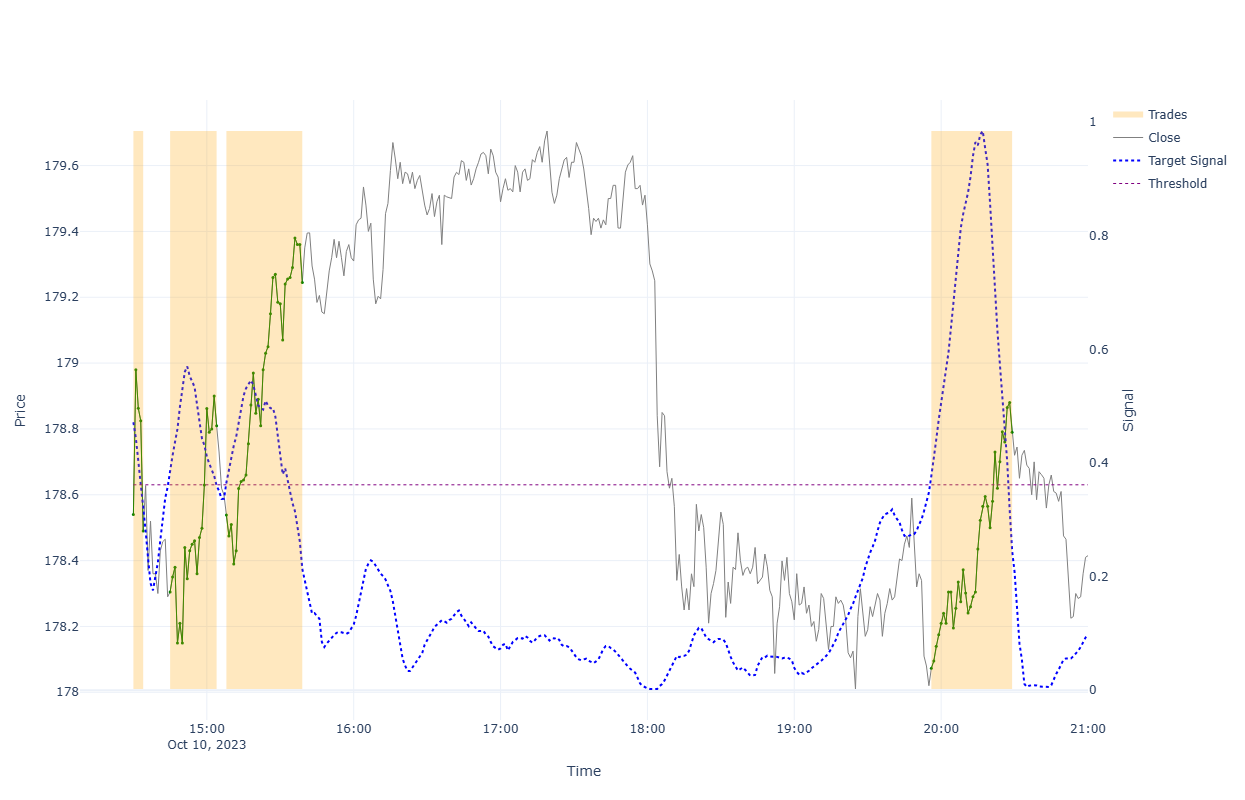

  Buy & Hold Return ($): -0.304
  Strategy Return ($): 1.164
  Trades Returns ($): [-0.229, 0.326, 0.527, 0.538]
-------------------------------------------------------------------------------------------------------------------------------------------------


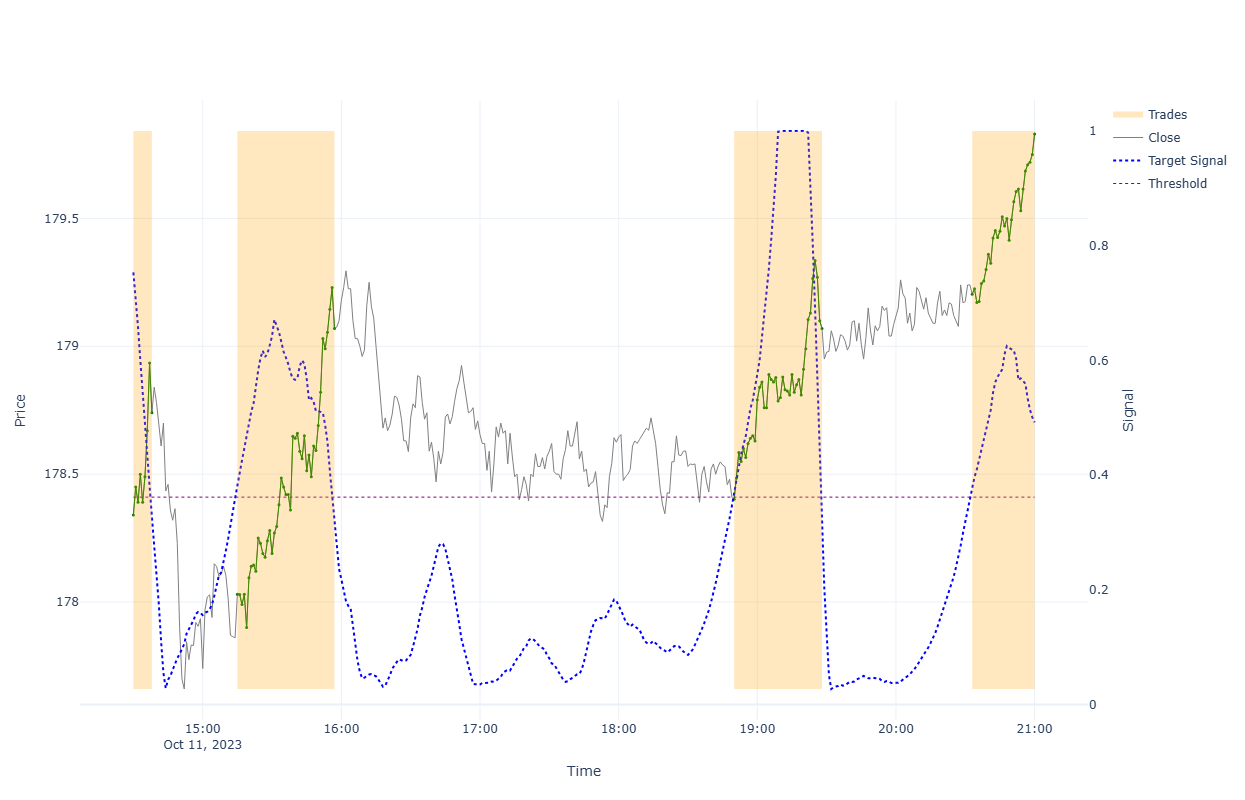

  Buy & Hold Return ($): 1.311
  Strategy Return ($): 2.019
  Trades Returns ($): [0.221, 0.862, 0.489, 0.446]
-------------------------------------------------------------------------------------------------------------------------------------------------


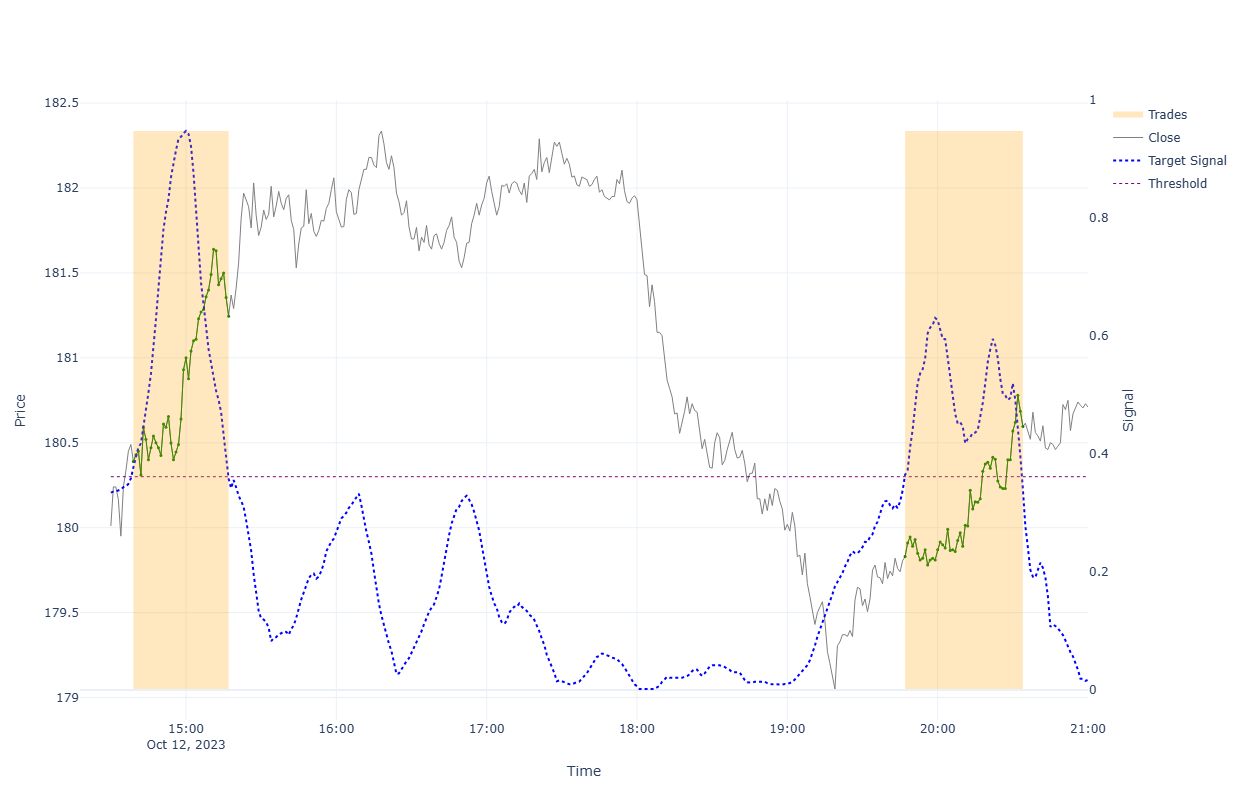

  Buy & Hold Return ($): 0.52
  Strategy Return ($): 1.259
  Trades Returns ($): [0.675, 0.585]
-------------------------------------------------------------------------------------------------------------------------------------------------


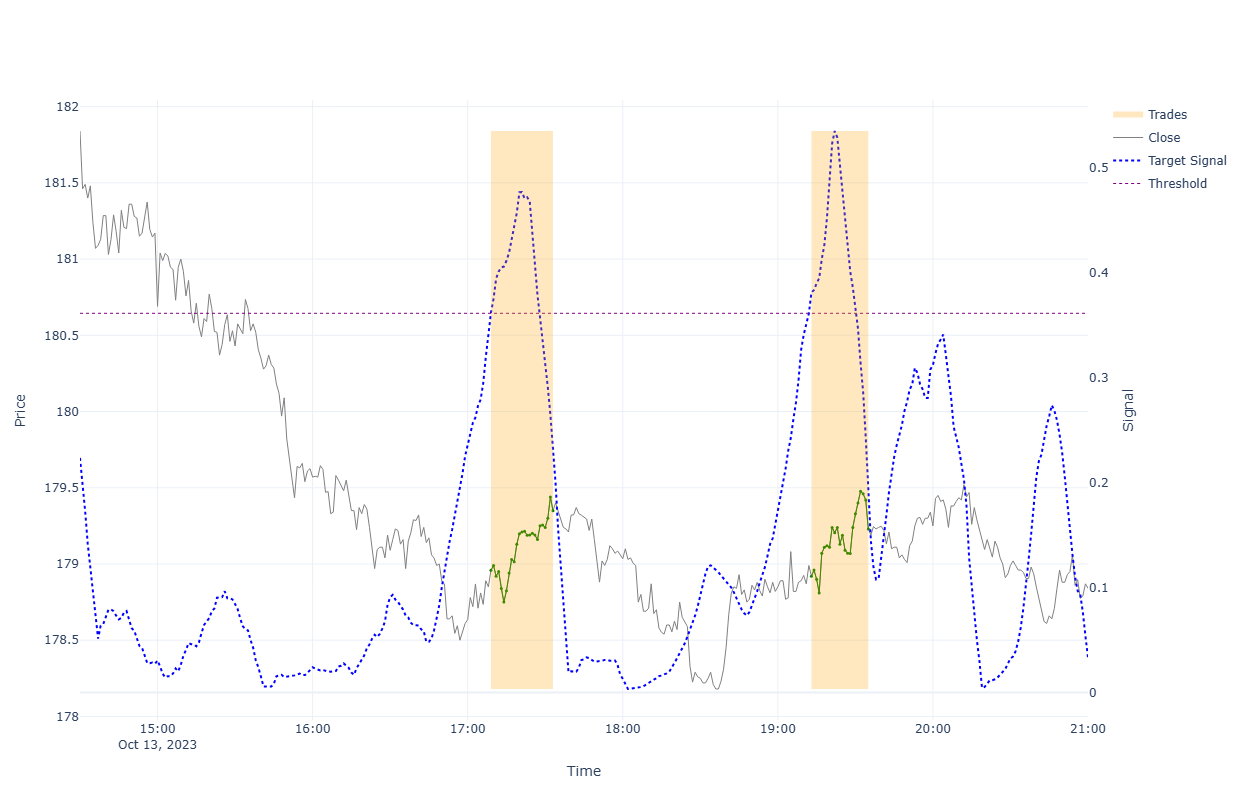

  Buy & Hold Return ($): -3.18
  Strategy Return ($): 0.343
  Trades Returns ($): [0.211, 0.131]
-------------------------------------------------------------------------------------------------------------------------------------------------


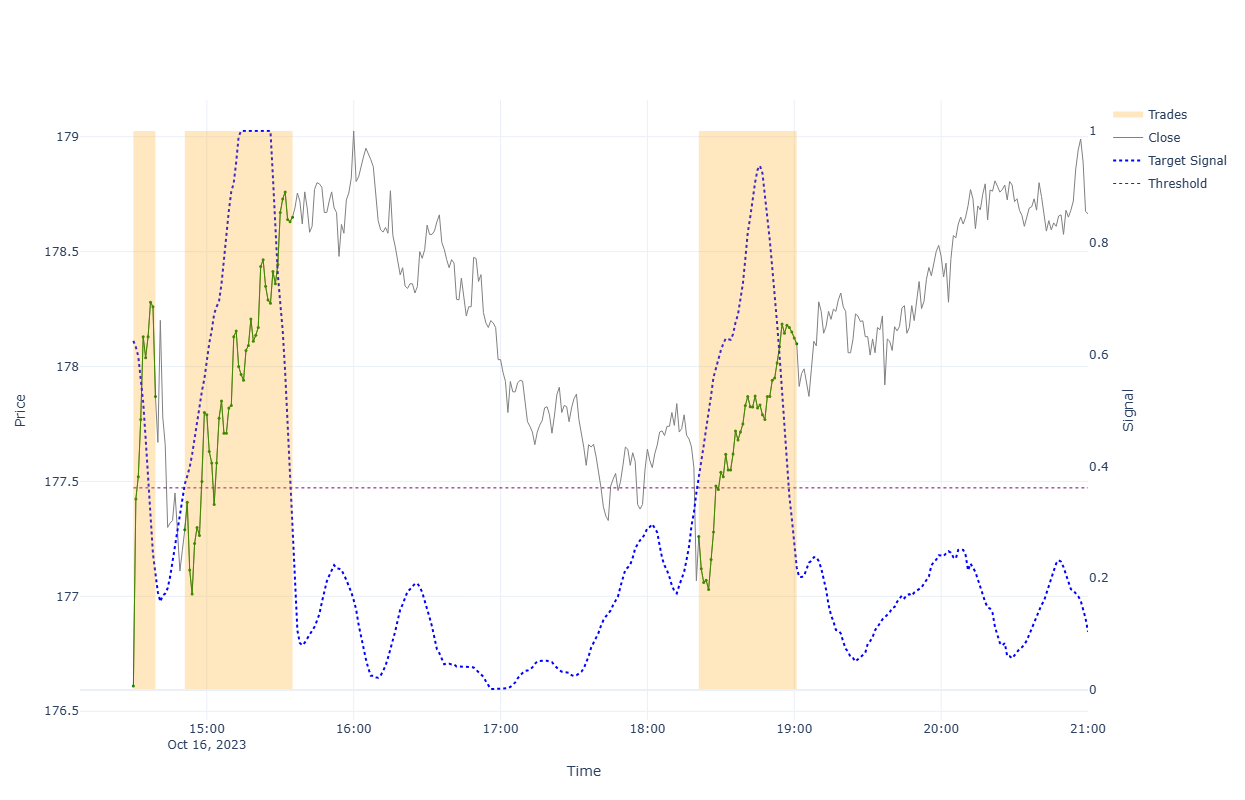

  Buy & Hold Return ($): 1.877
  Strategy Return ($): 2.926
  Trades Returns ($): [1.083, 1.181, 0.662]
-------------------------------------------------------------------------------------------------------------------------------------------------


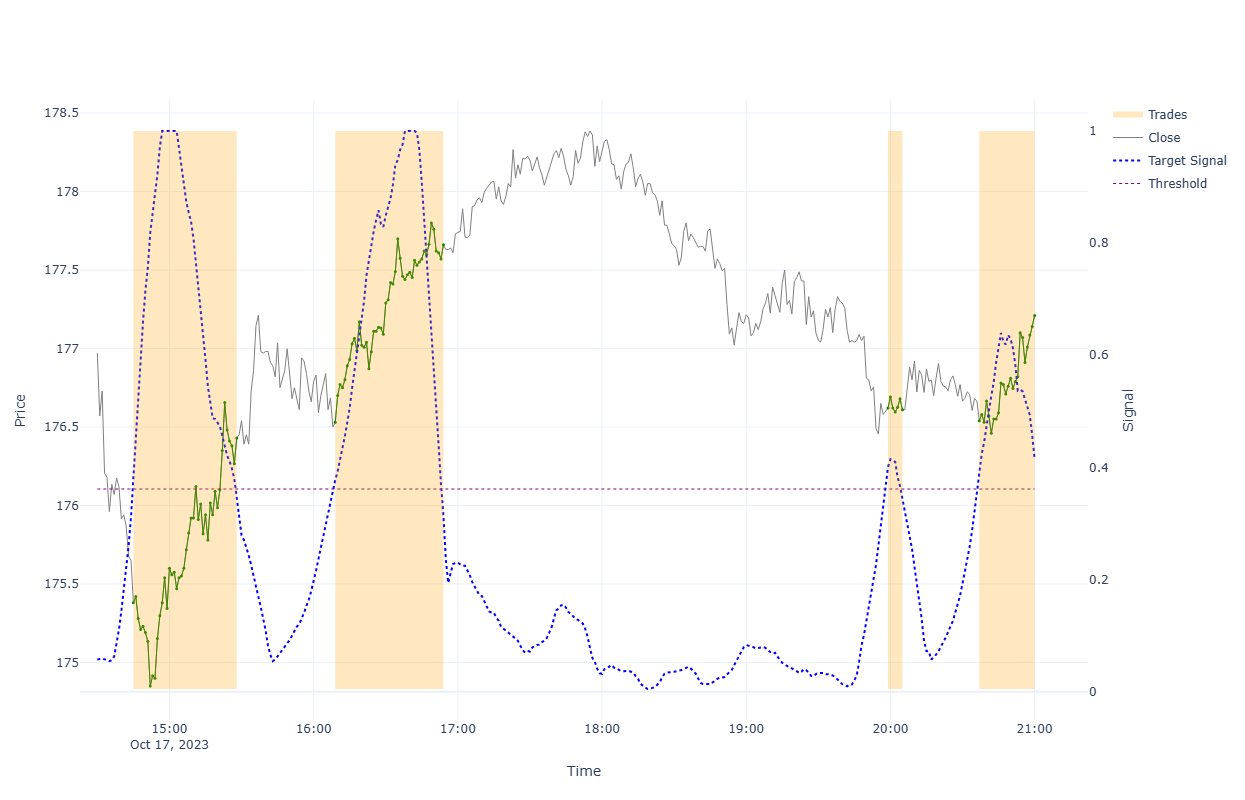

  Buy & Hold Return ($): 0.063
  Strategy Return ($): 2.134
  Trades Returns ($): [0.874, 0.954, -0.187, 0.493]
-------------------------------------------------------------------------------------------------------------------------------------------------


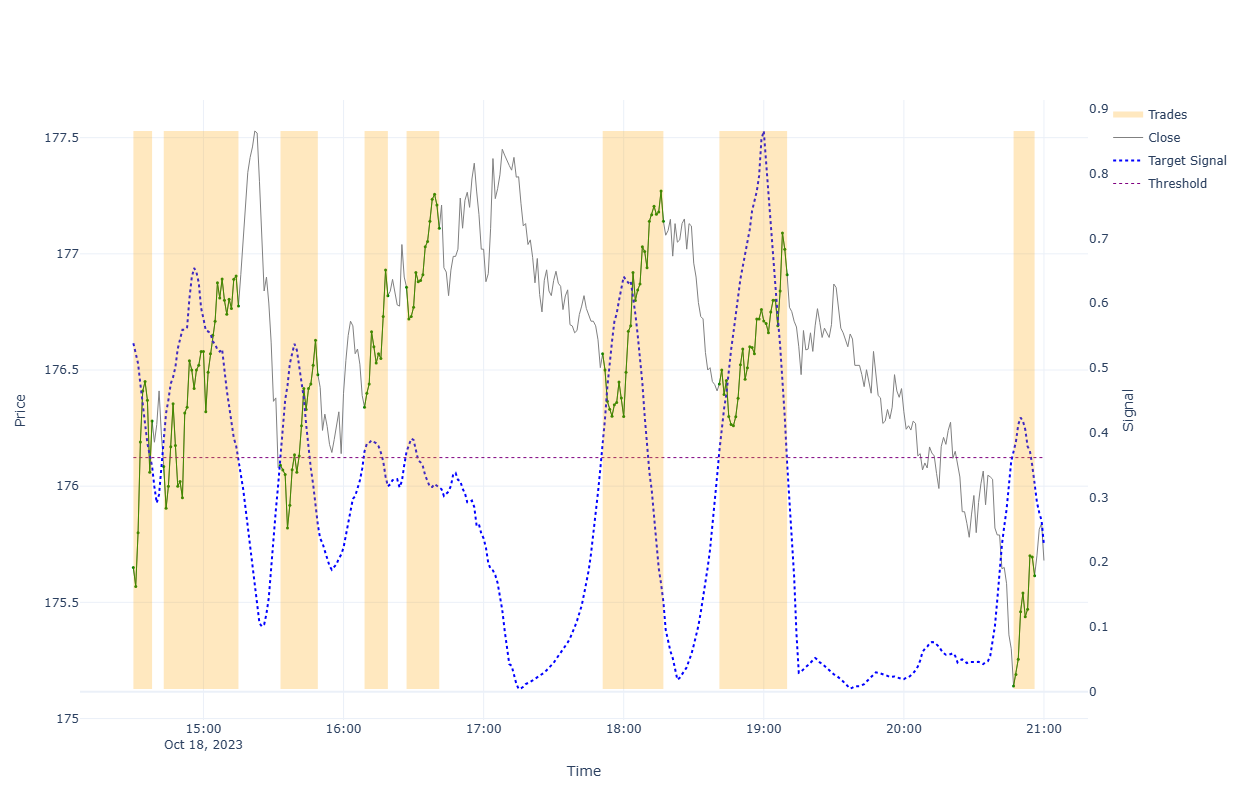

  Buy & Hold Return ($): -0.146
  Strategy Return ($): 2.548
  Trades Returns ($): [0.453, 0.514, 0.213, 0.303, 0.078, 0.394, 0.293, 0.3]
-------------------------------------------------------------------------------------------------------------------------------------------------


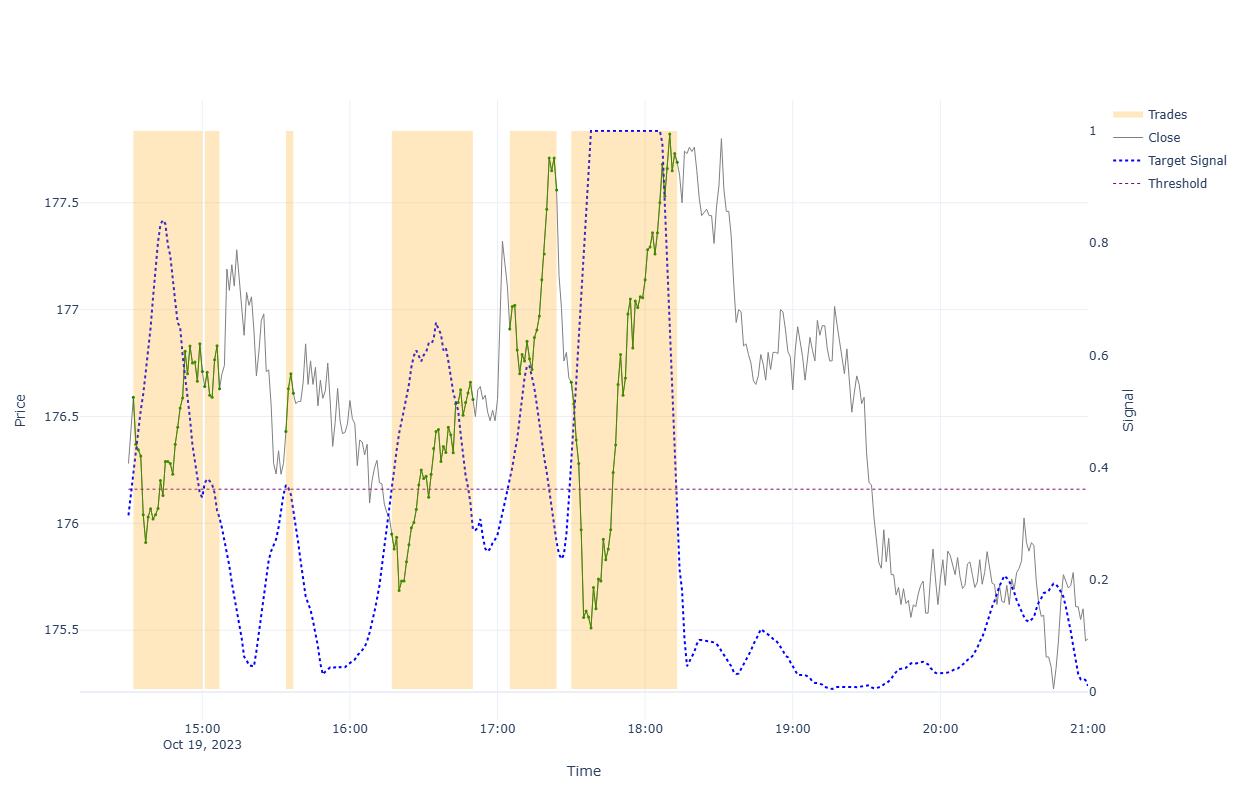

  Buy & Hold Return ($): -0.996
  Strategy Return ($): 1.537
  Trades Returns ($): [-0.057, -0.187, 0.002, 0.452, 0.473, 0.854]
-------------------------------------------------------------------------------------------------------------------------------------------------


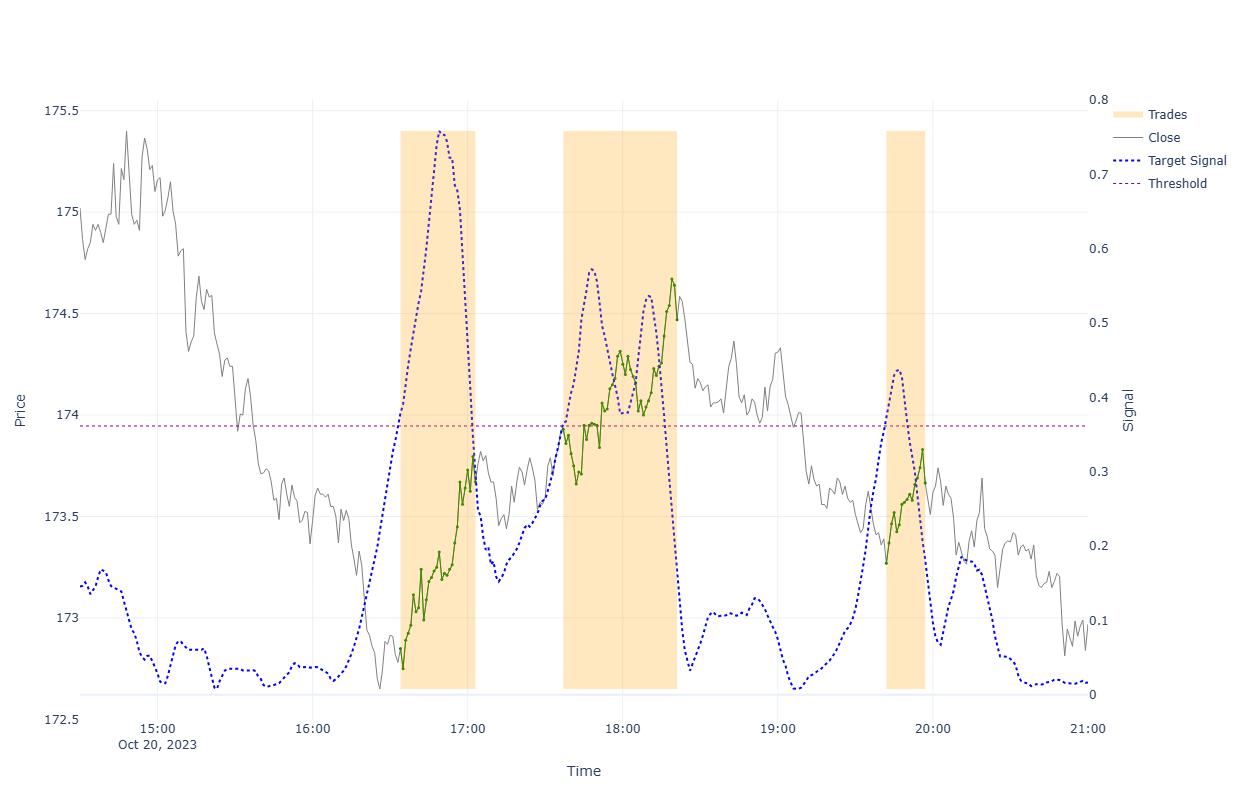

  Buy & Hold Return ($): -2.224
  Strategy Return ($): 1.234
  Trades Returns ($): [0.647, 0.365, 0.222]
-------------------------------------------------------------------------------------------------------------------------------------------------


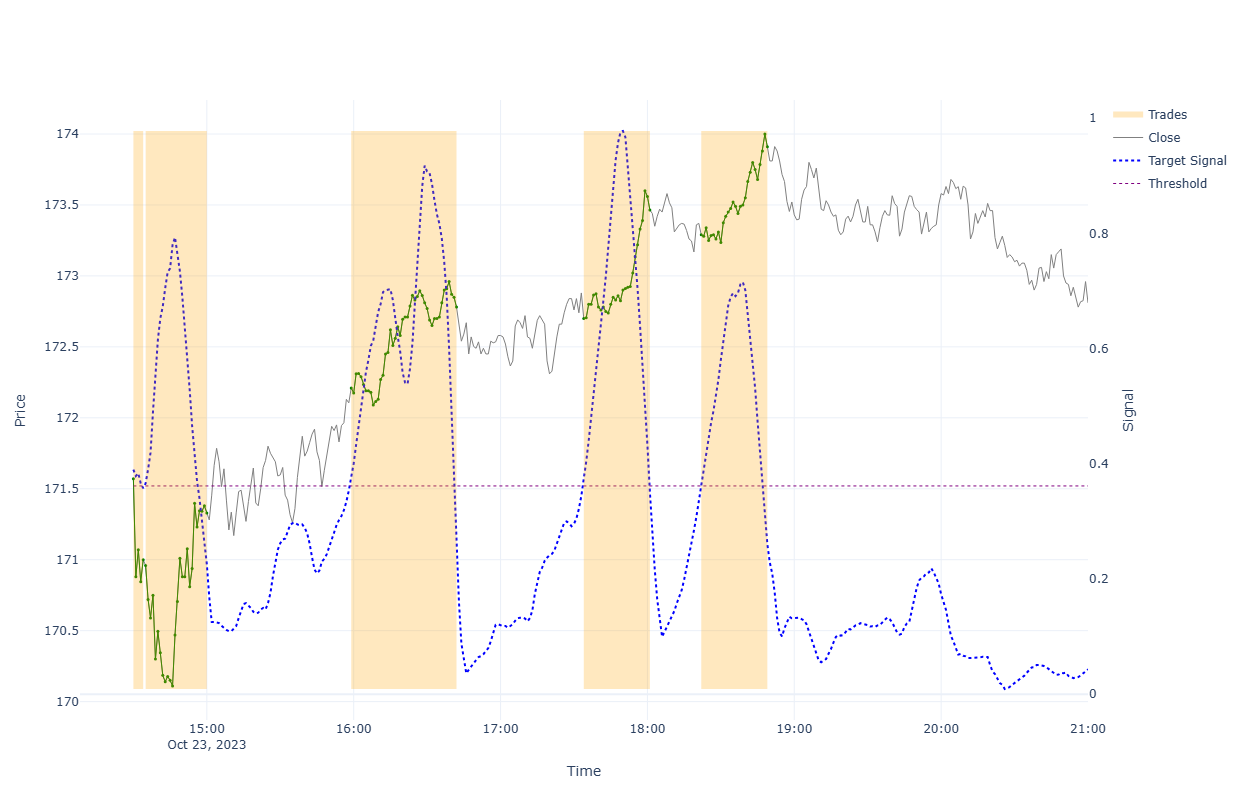

  Buy & Hold Return ($): 1.068
  Strategy Return ($): 0.893
  Trades Returns ($): [-0.742, 0.198, 0.398, 0.593, 0.446]
-------------------------------------------------------------------------------------------------------------------------------------------------


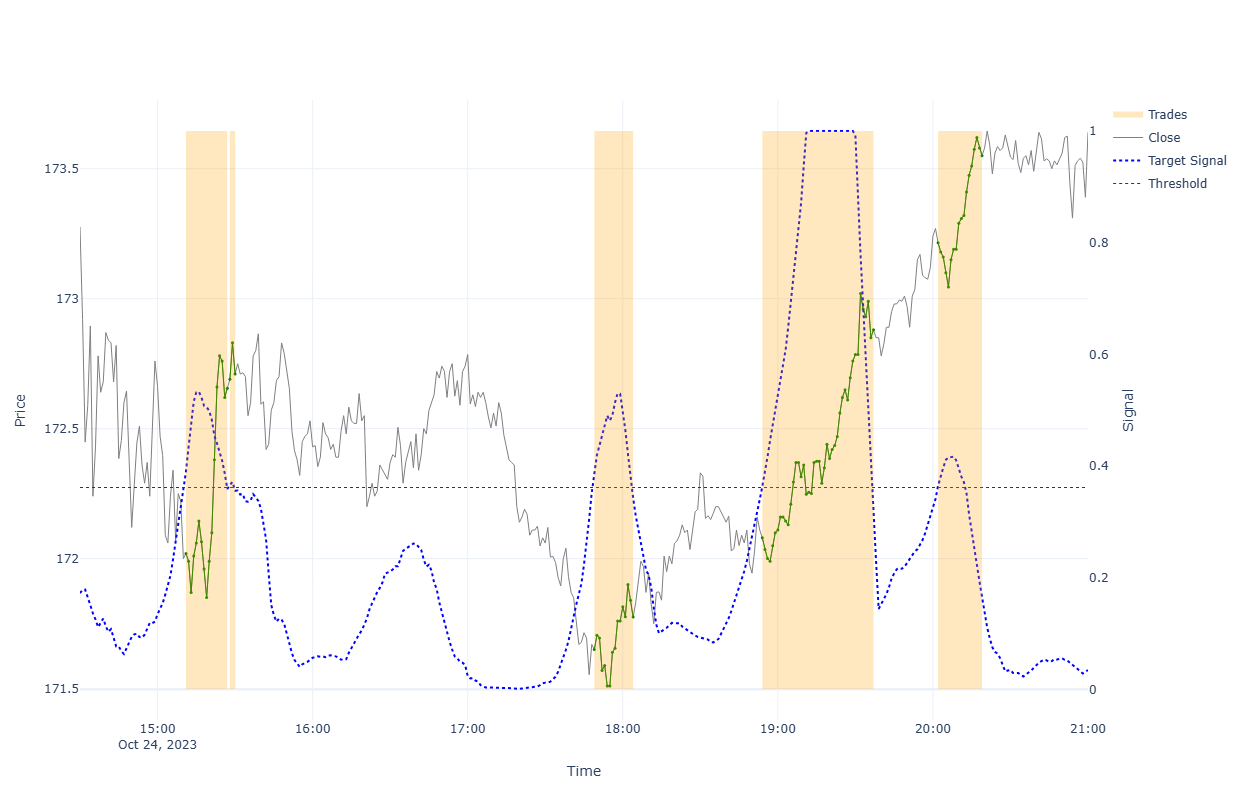

  Buy & Hold Return ($): 0.19
  Strategy Return ($): 1.052
  Trades Returns ($): [0.463, -0.152, -0.046, 0.628, 0.161]
-------------------------------------------------------------------------------------------------------------------------------------------------


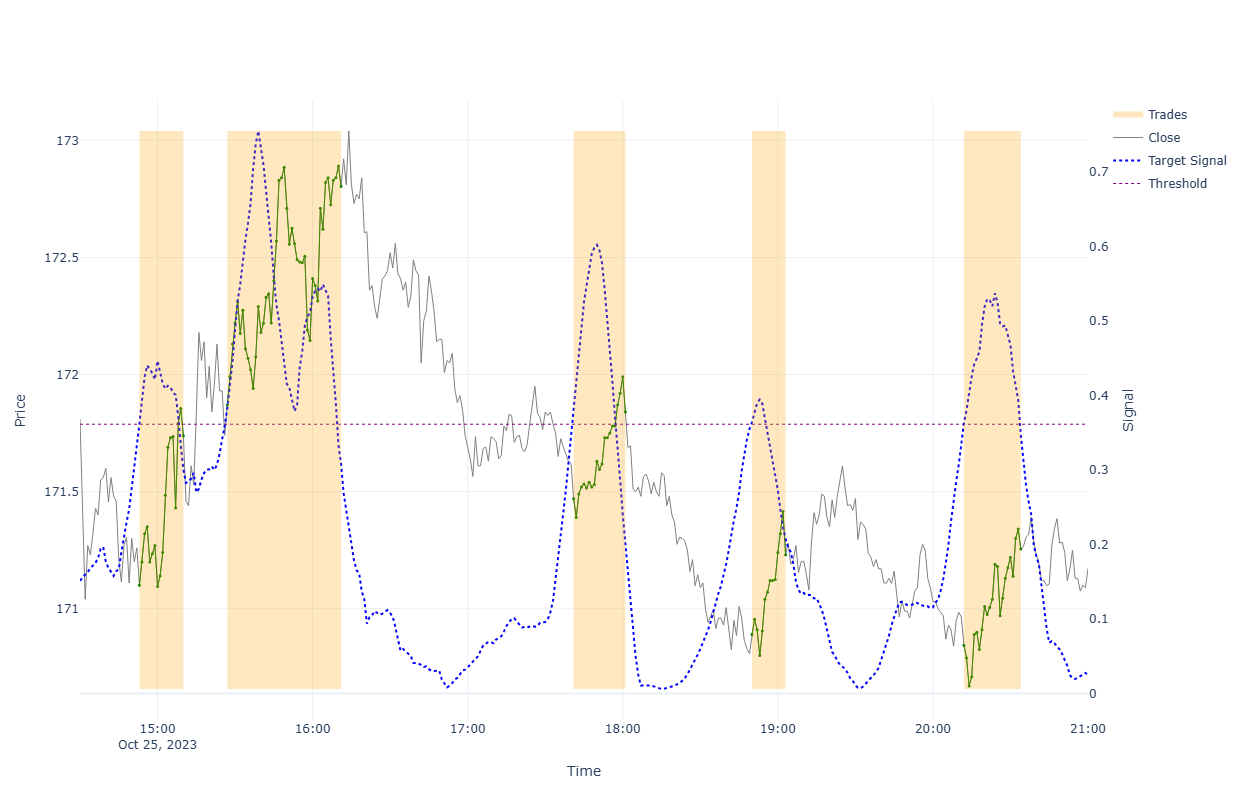

  Buy & Hold Return ($): -0.81
  Strategy Return ($): 1.835
  Trades Returns ($): [0.467, 0.76, 0.199, 0.169, 0.239]
-------------------------------------------------------------------------------------------------------------------------------------------------


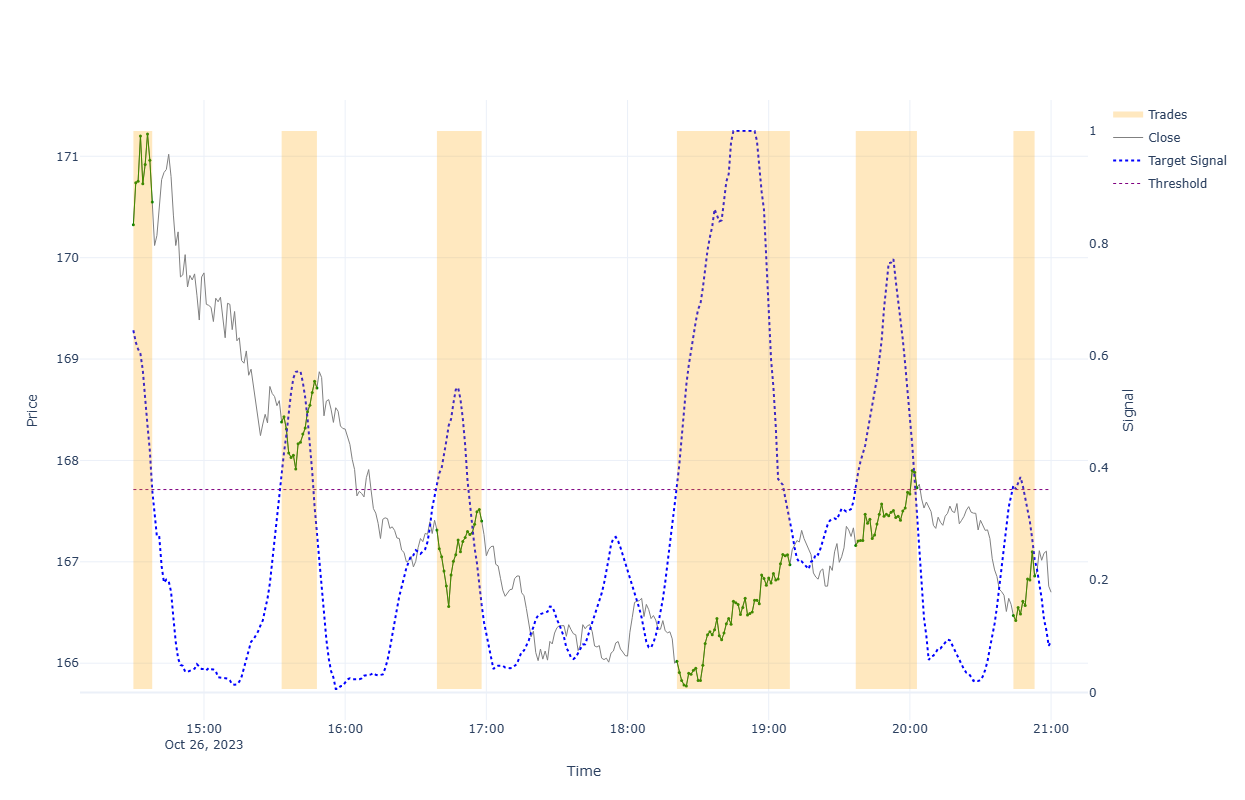

  Buy & Hold Return ($): -3.794
  Strategy Return ($): 1.551
  Trades Returns ($): [0.055, 0.167, -0.079, 0.784, 0.403, 0.223]
-------------------------------------------------------------------------------------------------------------------------------------------------


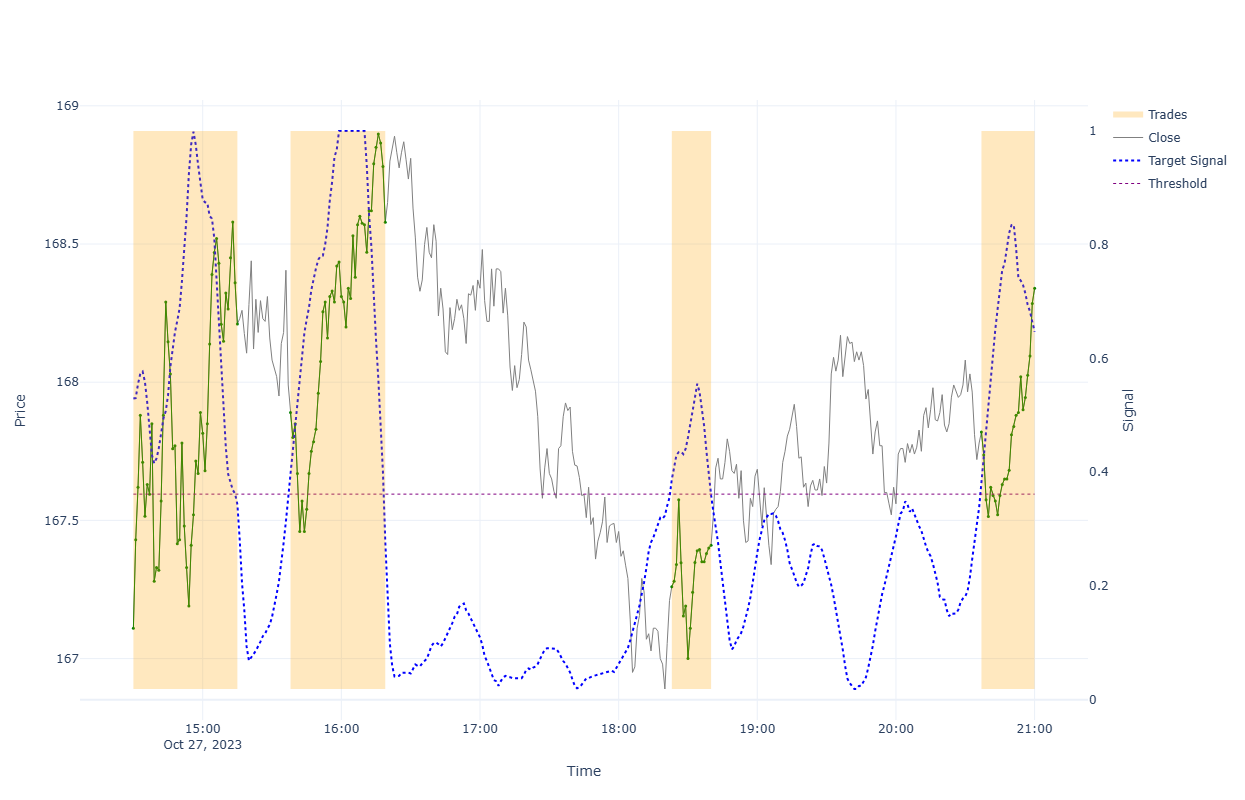

  Buy & Hold Return ($): 1.062
  Strategy Return ($): 1.788
  Trades Returns ($): [0.933, 0.521, -0.017, 0.353]
-------------------------------------------------------------------------------------------------------------------------------------------------


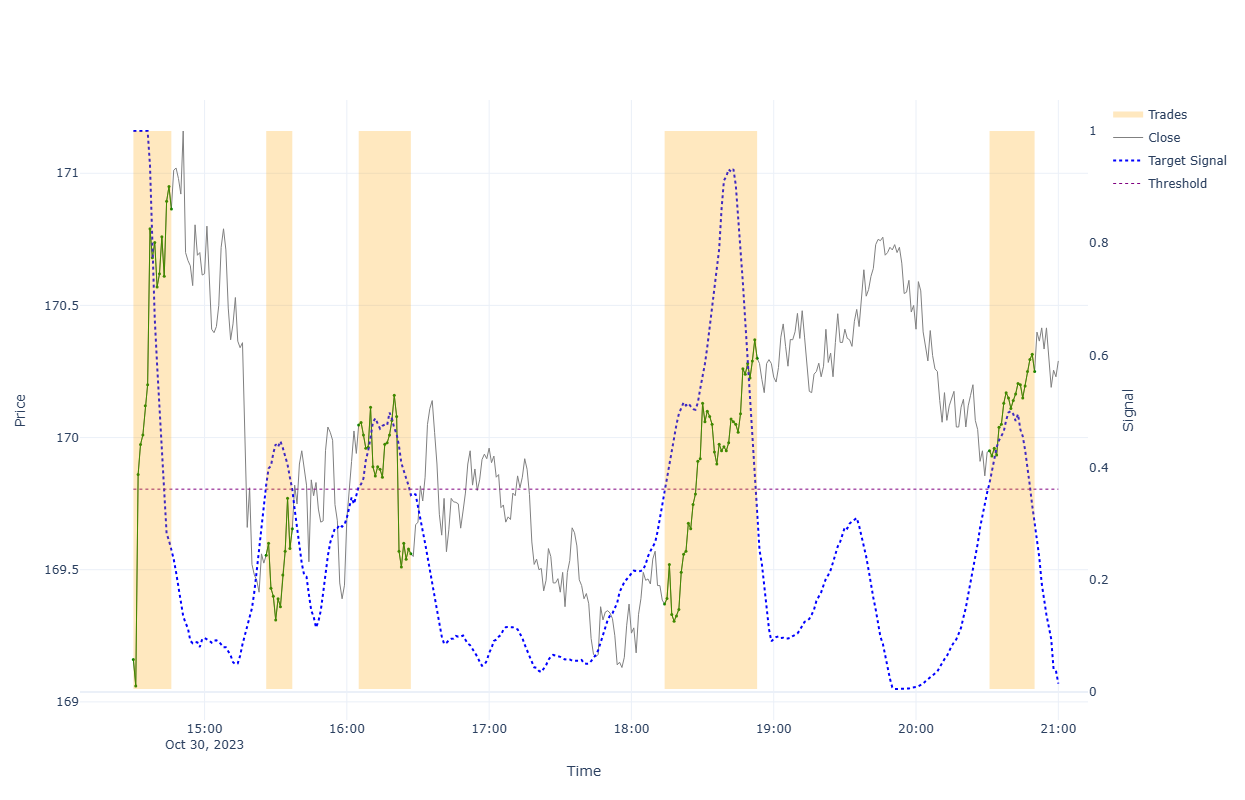

  Buy & Hold Return ($): 0.96
  Strategy Return ($): 1.698
  Trades Returns ($): [1.535, -0.07, -0.658, 0.761, 0.129]
-------------------------------------------------------------------------------------------------------------------------------------------------


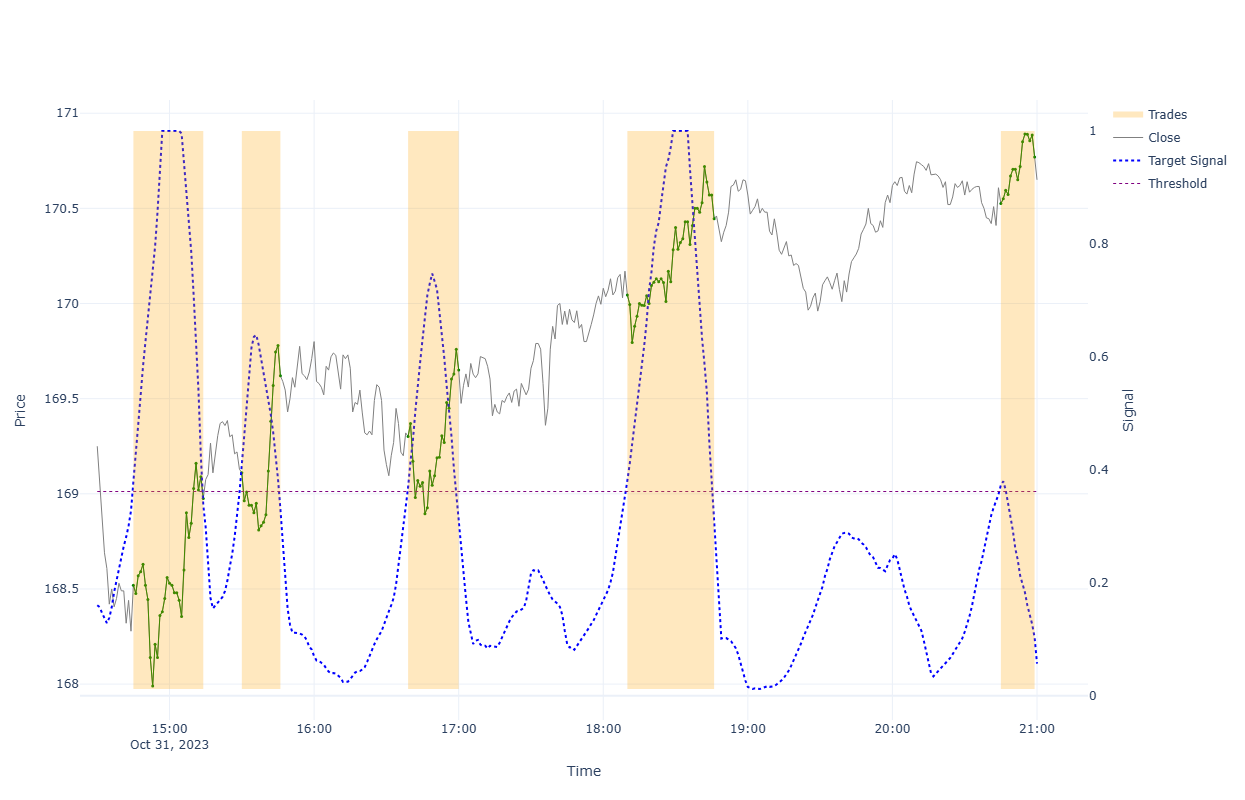

  Buy & Hold Return ($): 1.23
  Strategy Return ($): 1.111
  Trades Returns ($): [0.287, 0.34, 0.18, 0.23, 0.075]

Overall Summary (2023-10-02 = 171.1956 → 2023-10-31 = 170.5647)

One-time buy&hold gain: -0.631
Buy & Hold – each day ($): 6.102
Strategy Return ($): 37.464
Trades Count: 101
Strategy return per trade: 0.371
Num. trading days: 22
Strategy return per trading day: 1.703


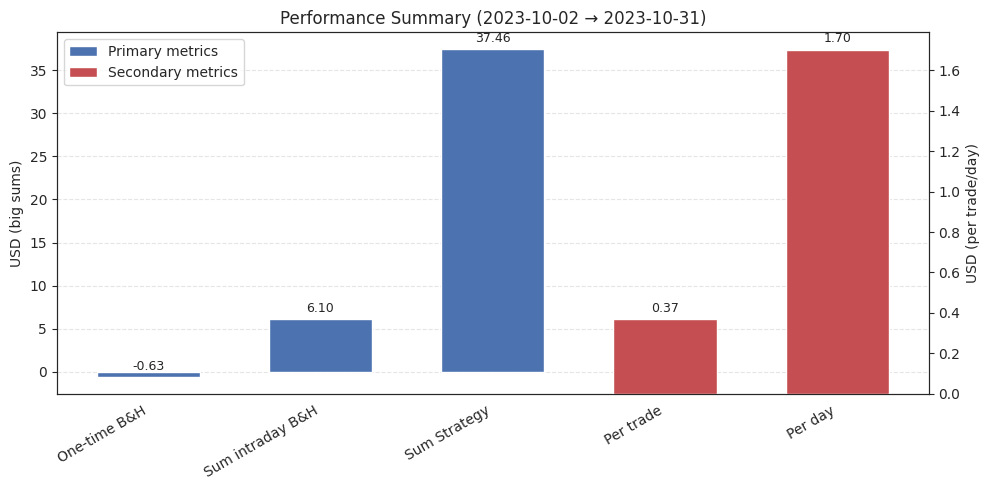

open    high     low    close      volume       ask  \
2023-10-02 09:00:00  172.190  173.00  171.71  172.890      2183.0  172.9764   
2023-10-02 09:01:00  172.770  172.91  172.73  172.900      1436.0  172.9864   
2023-10-02 09:02:00  172.840  172.93  172.79  172.840       475.0  172.9264   
2023-10-02 09:03:00  172.810  172.86  172.77  172.840       769.0  172.9264   
2023-10-02 09:04:00  172.840  172.90  172.84  172.900      2000.0  172.9864   
...                      ...     ...     ...      ...         ...       ...   
2023-10-31 20:56:00  170.895  170.90  170.83  170.890    192316.0  170.9754   
2023-10-31 20:57:00  170.890  170.90  170.84  170.855    179167.0  170.9404   
2023-10-31 20:58:00  170.860  170.89  170.81  170.885    211865.0  170.9704   
2023-10-31 20:59:00  170.880  170.90  170.71  170.770    844971.0  170.8554   
2023-10-31 21:00:00  170.760  170.77  170.65  170.650  12392337.0  170.7353   

                          bid    signal_raw        signal  signal_action  \
2023-10-02 09:00:00  172.8036  3.576687e-16  3.608112e-12              0   
2023-10-02 09:01:00  172.8136  3.729480e-16  3.824793e-12              0   
2023-10-02 09:02:00  172.7536  4.890761e-16  4.097150e-12              0   
2023-10-02 09:03:00  172.7536  5.281821e-16  4.403305e-12              0   
2023-10-02 09:04:00  172.8136  4.697535e-16  4.708174e-12              0   
...                       ...           ...           ...            ...   
2023-10-31 20:56:00  170.8046  0.000000e+00  1.598823e-01              0   
2023-10-31 20:57:00  170.7696  0.000000e+00  1.432019e-01              0   
2023-10-31 20:58:00  170.7996  0.000000e+00  1.263179e-01              0   
2023-10-31 20:59:00  170.6846  0.000000e+00  1.029096e-01             -1   
2023-10-31 21:00:00  170.5647  0.000000e+00  5.681452e-02              0   

                     Position     Cash  NetValue    Action  TradedAmount  \
2023-10-02 09:00:00         0    0.000     0.000  No trade             0   
2023-10-02 09:01:00         0    0.000     0.000  No trade             0   
2023-10-02 09:02:00         0    0.000     0.000  No trade             0   
2023-10-02 09:03:00         0    0.000     0.000  No trade             0   
2023-10-02 09:04:00         0    0.000     0.000  No trade             0   
...                       ...      ...       ...       ...           ...   
2023-10-31 20:56:00         1 -169.574     1.231      Hold             0   
2023-10-31 20:57:00         1 -169.574     1.196      Hold             0   
2023-10-31 20:58:00         1 -169.574     1.226      Hold             0   
2023-10-31 20:59:00         0    1.111     1.111      Sell            -1   
2023-10-31 21:00:00         0    1.111     1.111  No trade             0   

                     BuyHoldEarning  StrategyEarning  EarningDiff  
2023-10-02 09:00:00           0.000            0.000        0.000  
2023-10-02 09:01:00           0.000            0.000        0.000  
2023-10-02 09:02:00           0.000            0.000        0.000  
2023-10-02 09:03:00           0.000            0.000        0.000  
2023-10-02 09:04:00           0.000            0.000        0.000  
...                             ...              ...          ...  
2023-10-31 20:56:00           1.470            1.231       -0.239  
2023-10-31 20:57:00           1.435            1.196       -0.239  
2023-10-31 20:58:00           1.465            1.226       -0.239  
2023-10-31 20:59:00           1.350            1.111       -0.239  
2023-10-31 21:00:00           1.230            1.111       -0.119  

[15862 rows x 18 columns]

In [5]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

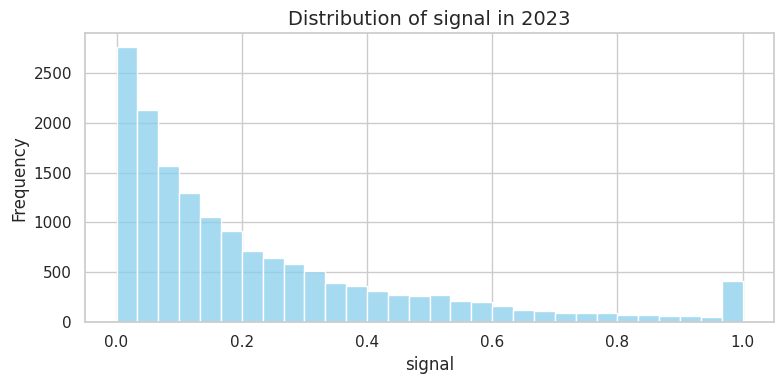

signal_min  signal_max  signal_mean  signal_median  close_return
2023-10         0.0         1.0     0.226378       0.139765      0.099899

In [6]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
